In [3]:
# loading all the necessary libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
import os

Matplotlib is building the font cache; this may take a moment.


## Read and prepare data

In [3]:
"""Reading the files""" 
filepath = '../content/embarcacoes/'
df = pd.read_csv(filepath+'embacacoes.csv')  


In [4]:
"""Select the boat trajectory and preparer the **M** matrix"""
trajectory = 20 # boat trajectory
M = df.values # matrix of data 
pos = np.argwhere(M[:,12] == trajectory) # position of the boat 
M = M[pos[:,0],:] # matrix of data with the boat trajectory 
s = M[0:,7] # speed of the boat
s = np.array([s]).T # transpose of the speed vector


In [5]:
s

array([[0.1],
       [3.5],
       [5.0],
       ...,
       [3.1],
       [1.9],
       [0.1]], dtype=object)

In [7]:
trajectory = 20 # boat trajectory
M = df.values # matrix of data 
pos = np.argwhere(M[:,12] == trajectory) # position of the boat 
M = M[pos[:,0],:] # matrix of data with the boat trajectory 
s = M[0:,7] # speed of the boat
s = np.array([s]).T # transpose of the speed vector

k = 2 # number of gausians 
[trajectory, Dim] = s.shape # dimension of the data

aux = np.random.choice(trajectory, trajectory, replace=False)
w = s[aux[0:k],:]

for j in range(0,5):
    rot = np.array([])
    for n in range(0, trajectory):
        rot = np.append(rot, np.argmin(sum(pow(np.ones((k,1))*s[n, :]-w, 2).T))  )
    for m in range(0, k):
        w[m,:] = np.mean(s[np.where(rot == m), :], axis=1)

del aux, j, n, m 

In [12]:
w.shape

(2, 1)

In [14]:
c = np.zeros((k,Dim,Dim))
for i in range(0, k):
    aux = s[np.where(rot == i)[0],:] - w[i, :]
    c[i,:,:] = np.dot(aux.T, aux)/trajectory
del aux, i

In [16]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
likehood = []
fig.show()
fig.canvas.draw()

for l in range(0,1):
    P = np.zeros((N,k))
    for j in range(0,N):
        for i in range(0,k):
            temp1 = 1/(pow(2*np.pi,Dim/2)*np.linalg.det(c[i,:, :]))
            temp2 = np.dot(s[j,:]-w[i,:], np.dot(np.linalg.inv(c[i,:,:]),(s[j,:]-w[i,:])))
            pi = 1/4*np.ones((k,1));
            P[j,i] = pi[i,0]*temp1*np.exp(-1/2*temp2)
    del temp1, temp2, i, j
    L = P
    den = np.sum(L, axis = 1)
    for j in range(0, k):
        for n in range(0, N):
            L[n,j] = P[n,j]/den[n]
    del n, j   
    Nk = np.sum(L, axis = 0)
    uknovo = np.zeros((w.shape))
    uknovo[0,:] = 1/Nk[0]*np.sum(L[:,0]*s.T,axis = 1)
    uknovo[1,:] = 1/Nk[1]*np.sum(L[:,1]*s.T,axis = 1)

    #ajustar covariância
    cknovo = np.zeros((k,Dim,Dim))
    for i in range(0, k):#len(u)):
        aux = s - uknovo[i, :]
        cknovo[i,:,:] = np.dot(L[:,i]*aux.T, aux)/Nk[i]

    del aux
    w = uknovo
    c = cknovo
    likehood = np.append(likehood,sum(np.log(np.sum(L, axis=1))))
    rot = np.zeros((trajectory))
    for n in range(0, trajectory):
        rot[n] = int(np.argmax(L[n,:])+1)

   
    ax.clear()
    ax.plot(s[np.where(rot == 1)[0], 0], '*b')
    ax.plot(s[np.where(rot == 2)[0], 0], '*r')
       
    fig.canvas.draw()


<IPython.core.display.Javascript object>

NameError: name 'N' is not defined

In [11]:
%matplotlib notebook
plt.plot(M[np.where(rot == 1),10].T, M[np.where(rot == 1),9].T, 'b*')
plt.plot(M[np.where(rot == 2),10].T, M[np.where(rot == 2),9].T, 'r*')


<IPython.core.display.Javascript object>

In [12]:
pos_f = np.argwhere(rot == 1)
pos_c = np.argwhere(rot == 2)
Uc_t , Nc_t= np.unique(rot[pos_c[:-1,0]+1], return_counts = True)
Uf_t , Nf_t= np.unique(rot[pos_f[:-2,0]+1], return_counts = True)   
%matplotlib widget
plt.plot(Uc_t, Nc_t/(np.sum(Nf_t)+np.sum(Nc_t)), '*r')
plt.plot(Uf_t, Nf_t/(np.sum(Nf_t)+np.sum(Nc_t)), '*b')
Nc_t/(+np.sum(Nc_t)),Nf_t/(np.sum(Nf_t))

a = np.array([Nf_t/(np.sum(Nf_t)),Nc_t/(+np.sum(Nc_t))])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


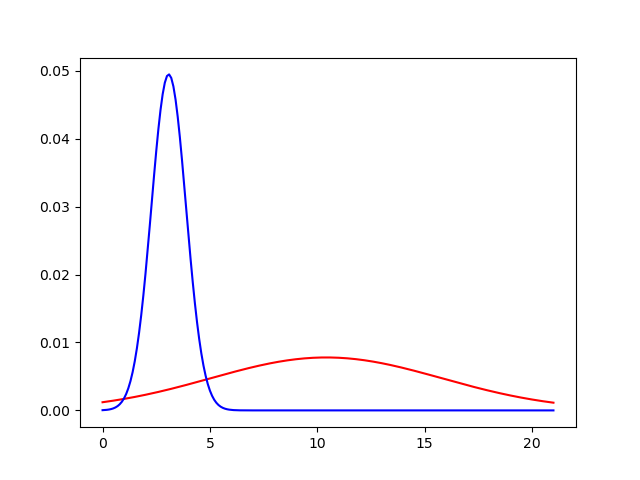

In [13]:
%matplotlib widget 
t = np.linspace(0,21,211)

g1 = 1/(c[0]*np.sqrt(2*np.pi))*np.exp(-1/2*pow((t-w[0])/c[0], 2))
g2 = 1/(c[1]*np.sqrt(2*np.pi))*np.exp(-1/2*pow((t-w[1])/c[1], 2))
plt.plot(t,g1.T/np.sum(g1),'r')
plt.plot(t,g2.T/np.sum(g2),'b')

In [14]:
b = np.array([g1[0,:].T/np.sum(g1),g2[0,:].T/np.sum(g2)])
b.shape
b = pd.DataFrame(b.T,columns=["cruzeiro","pesca" ])
b.to_csv (r'C:/Users/victo/Desktop/university/Courses/reconhecimento_de_padrao/Markov_Python/content/distribution/b.csv', index = False, header=True, encoding='utf-8')
a = pd.DataFrame(a)
a.to_csv (r'C:/Users/victo/Desktop/university/Courses/reconhecimento_de_padrao/Markov_Python/content/distribution/a.csv', index = False, header=True, encoding='utf-8')


# Ler distribuição de probabilidade inicial das velocidades 

In [15]:
filepath = 'C:/Users/victo/Desktop/university/Courses/reconhecimento_de_padrao/projeto/fishing_finder/content/distribution/'
a = pd.read_csv(filepath+'a.csv')#probabilidade de mudar de estado
b = pd.read_csv(filepath+'b.csv')#probabilidade dos eventos de velocidade
a = a.values
b = b.values
pi = np.array([0,1])#variavel da probabilidade 

### distribuição inicial das velocidades 

<IPython.core.display.Javascript object>


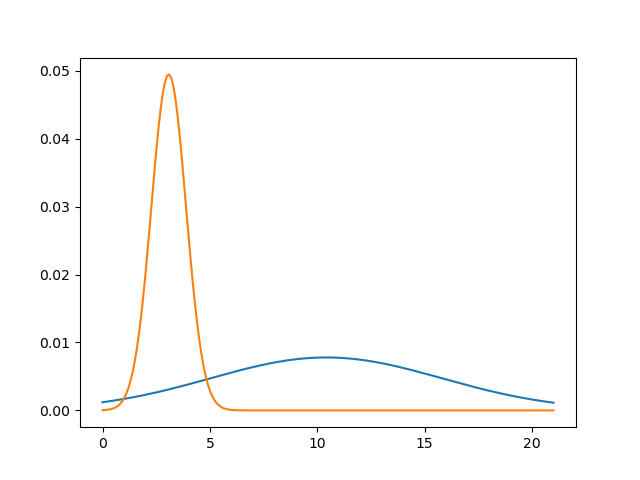

In [17]:
%matplotlib notebook
x = np.arange(0,21.1,0.1)
plt.plot(x,b[:,1])
plt.plot(x,b[:,0])

In [18]:
len(b)

211

<IPython.core.display.Javascript object>


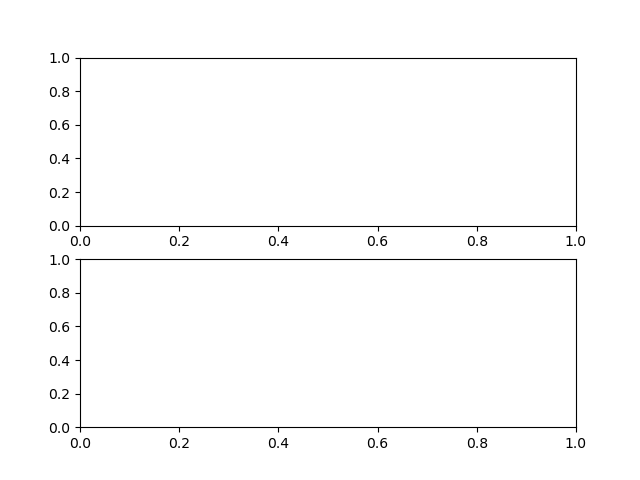

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plt.ion()
fig.show()
fig.canvas.draw()

erro = np.array([]) 
for z in range(0,10):
    ###################################### Algoritmo Foward #########################
    alpha = np.zeros((2,len(s)))
    eta = np.zeros(len(s))
    
    alpha[:,0] = pi*b[int(s[0]*10),:]
    eta[0] = np.sum(alpha[:,0])
    alpha[:,0] = alpha[:,0]/eta[0]
    #print(alpha[:,0])
    for T in range(0, len(s)-1):
        for j in range(0,2):
            for i in range(0,2):
                alpha[j,T+1] = alpha[j,T+1] + alpha[i,T]*a[i,j]*b[int(s[T+1]*10),j]#
        eta[T+1] = np.sum(alpha[:,T+1])
        alpha[:,T+1] = alpha[:,T+1]/eta[T+1]
        
    
    ############################ algoritmo Backward  ########################
    beta = np.zeros((2,len(s)))
    beta[1,-1] = 1
    del i, j
    for T in range(len(s)-2, -1, -1): 
        for i in range(0,2):
            for j in range(0,2):
                beta[i,T] = beta[i,T] + beta[j,T+1]*a[i,j]*b[int(s[T+1]*10),j]#
        beta[:,T] = beta[:,T]/eta[T+1]  
    del i, j
    #################################### Calculo do Gamma  ##############################################
    gamma = np.zeros((2,len(s)))
    for t in range(0,len(s)):
        den  = 0
        den = np.sum(alpha[:,t]*beta[:,t])
        for i in range(0,2):
            gamma[i, t] = alpha[i, t]*beta[i, t]/den
    
    ################################### calculo do Zeta####################################
    zeta = np.zeros((2,2, len(s)-1 ))
    for t in range(0, len(s)-1):
        for i in range(0,2):
            for j in range(0,2):
                zeta[i, j, t] = alpha[i,t]*a[i,j]*b[int(s[t+1]*10),j]*beta[j, t+1]/(eta[t+1]*np.sum(alpha[:,t]*beta[:,t]))

    temp1 = np.sum(zeta, axis = 2)
    temp2 = np.sum(zeta, axis = 1)
    a_new = np.zeros((2,2))
    
    for i in range(0,2):
        for j in range(0,2):
            a_new[i, j] = temp1[i, j]/np.sum(temp1, axis = 1)[i]
    erro = np.append(erro, np.sum(np.abs(a-a_new)))
    a = np.copy(a_new)
    #########calculo das distribuicoes de probabilidade#################################################
    u1 = np.sum(gamma[0,:]*s[:,0])/np.sum(gamma[0,:])
    u2 = np.sum(gamma[1,:]*s[:,0])/np.sum(gamma[1,:])
    c1 = np.sum(gamma[0,:]*abs(s[:,0]-u1))/np.sum(gamma[0,:])
    c2 = np.sum(gamma[1,:]*abs(s[:,0]-u2))/np.sum(gamma[1,:])
    x = np.arange(0,21.1,0.1)
    
    g1 = 1/(c1*np.sqrt(2*np.pi))*np.exp(-1/2*pow((x-u1)/c1, 2))
    g2 = 1/(c2*np.sqrt(2*np.pi))*np.exp(-1/2*pow((x-u2)/c2, 2))
    
    b = np.array([g1/np.sum(g1),g2/np.sum(g2)]).T
    pi = gamma[:,0]  
   
    
    #################################################Plot######################################################
    
    ax1.clear()
    ax2.clear()
    ax1.plot(x,b[:,0], 'r')
    ax1.plot(x,b[:,1], 'b')
    ax2.plot(erro)
    fig.canvas.draw()
   

In [35]:
a

array([[0.97293116, 0.02706884],
       [0.04262699, 0.95737301]])

In [ ]:
rot = np.zeros(len(gamma.T))
for i in range(0,len(gamma.T)):
    
    if(gamma[0,i] > gamma[1,i]) :
        rot[i] = 1;
    else: 
        rot[i] = 0

In [ ]:
%matplotlib notebook

plt.plot(M[np.where(rot == 1),10].T, M[np.where(rot == 1),9].T, 'b*')
plt.plot(M[np.where(rot == 0),10].T, M[np.where(rot == 0),9].T, 'r*')

In [ ]:
rot = np.array([rot])
rot.shape

In [ ]:
v = np.array([M[:,9], M[:,10], rot[0,:]])
pd.DataFrame(v[:,pos[:,0]])
pos = np.argwhere(M[:, -1] == 19)
v = v[:,pos[:,0]]

%matplotlib notebook
plt.plot(v[0,np.where(v[2,:] == 1)].T, v[1,np.where(v[2,:] == 1)].T, '*b')
plt.plot(v[0,np.where(v[2,:] == 0)].T, v[1,np.where(v[2,:] == 0)].T, '*r')
plt.savefig("filepath.svg", format = 'svg', dpi=1000)


In [ ]:

%matplotlib notebook
s = M[0:,7] #vetor de velocidade do trajeto N
s = np.array([s]).T
s = s[pos[:,0]]
plt.plot(s[np.where(v[2,:] == 1)], '*r')
plt.plot(s[np.where(v[2,:] == 0)], '*b')